In [1]:
import numpy as np
import lbg_forecast.nz as nz
import lbg_forecast.emulator as em
import lbg_forecast.population_model as pop
import lbg_forecast.priors_gp_massfunc as gpmf
import lbg_forecast.dust_priors as dpr
import lbg_forecast.priors_gp_csfrd as gpsf
import matplotlib.pyplot as plt
import scipy as sc

In [2]:
# nz histogram parameters
dz = 0.1
minz = 0.0
maxz = 7.0
bins = np.arange(minz, maxz, dz)

mass_function_prior = gpmf.MassFunctionPrior()
dust_prior = dpr.DustPrior()
csfrd_prior = gpsf.CSFRDPrior()
model = em.fsps_emulator("/Users/fpetri/repos/LBGforecast")

In [7]:
nrealisations = 2
ngals = 1000
spsp = []
for n in range(nrealisations):
    sps_params = pop.generate_sps_parameters(ngals, mass_function_prior, dust_prior, csfrd_prior)
    spsp.append(sps_params)
    print("realisation: ", n)

realisation:  0
realisation:  1


In [8]:
nzs = []
batch_size=100
for n in range(nrealisations):    
    lbg_nzs = nz.simulate_nzs(spsp[n], model, batch_size)
    nzs.append(lbg_nzs)

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


TypeError: len() of unsized object

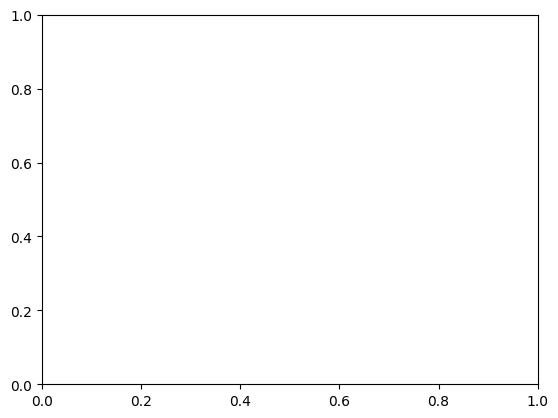

In [9]:
for n in range(nrealisations):
    hist = plt.hist(nzs[n][0], density=True, bins=bins, alpha = 0.1, color='blue')
    hist = plt.hist(nzs[n][1], density=True, bins=bins, alpha = 0.1, color='red')
    hist = plt.hist(nzs[n][2], density=True, bins=bins, alpha = 0.1, color='green')

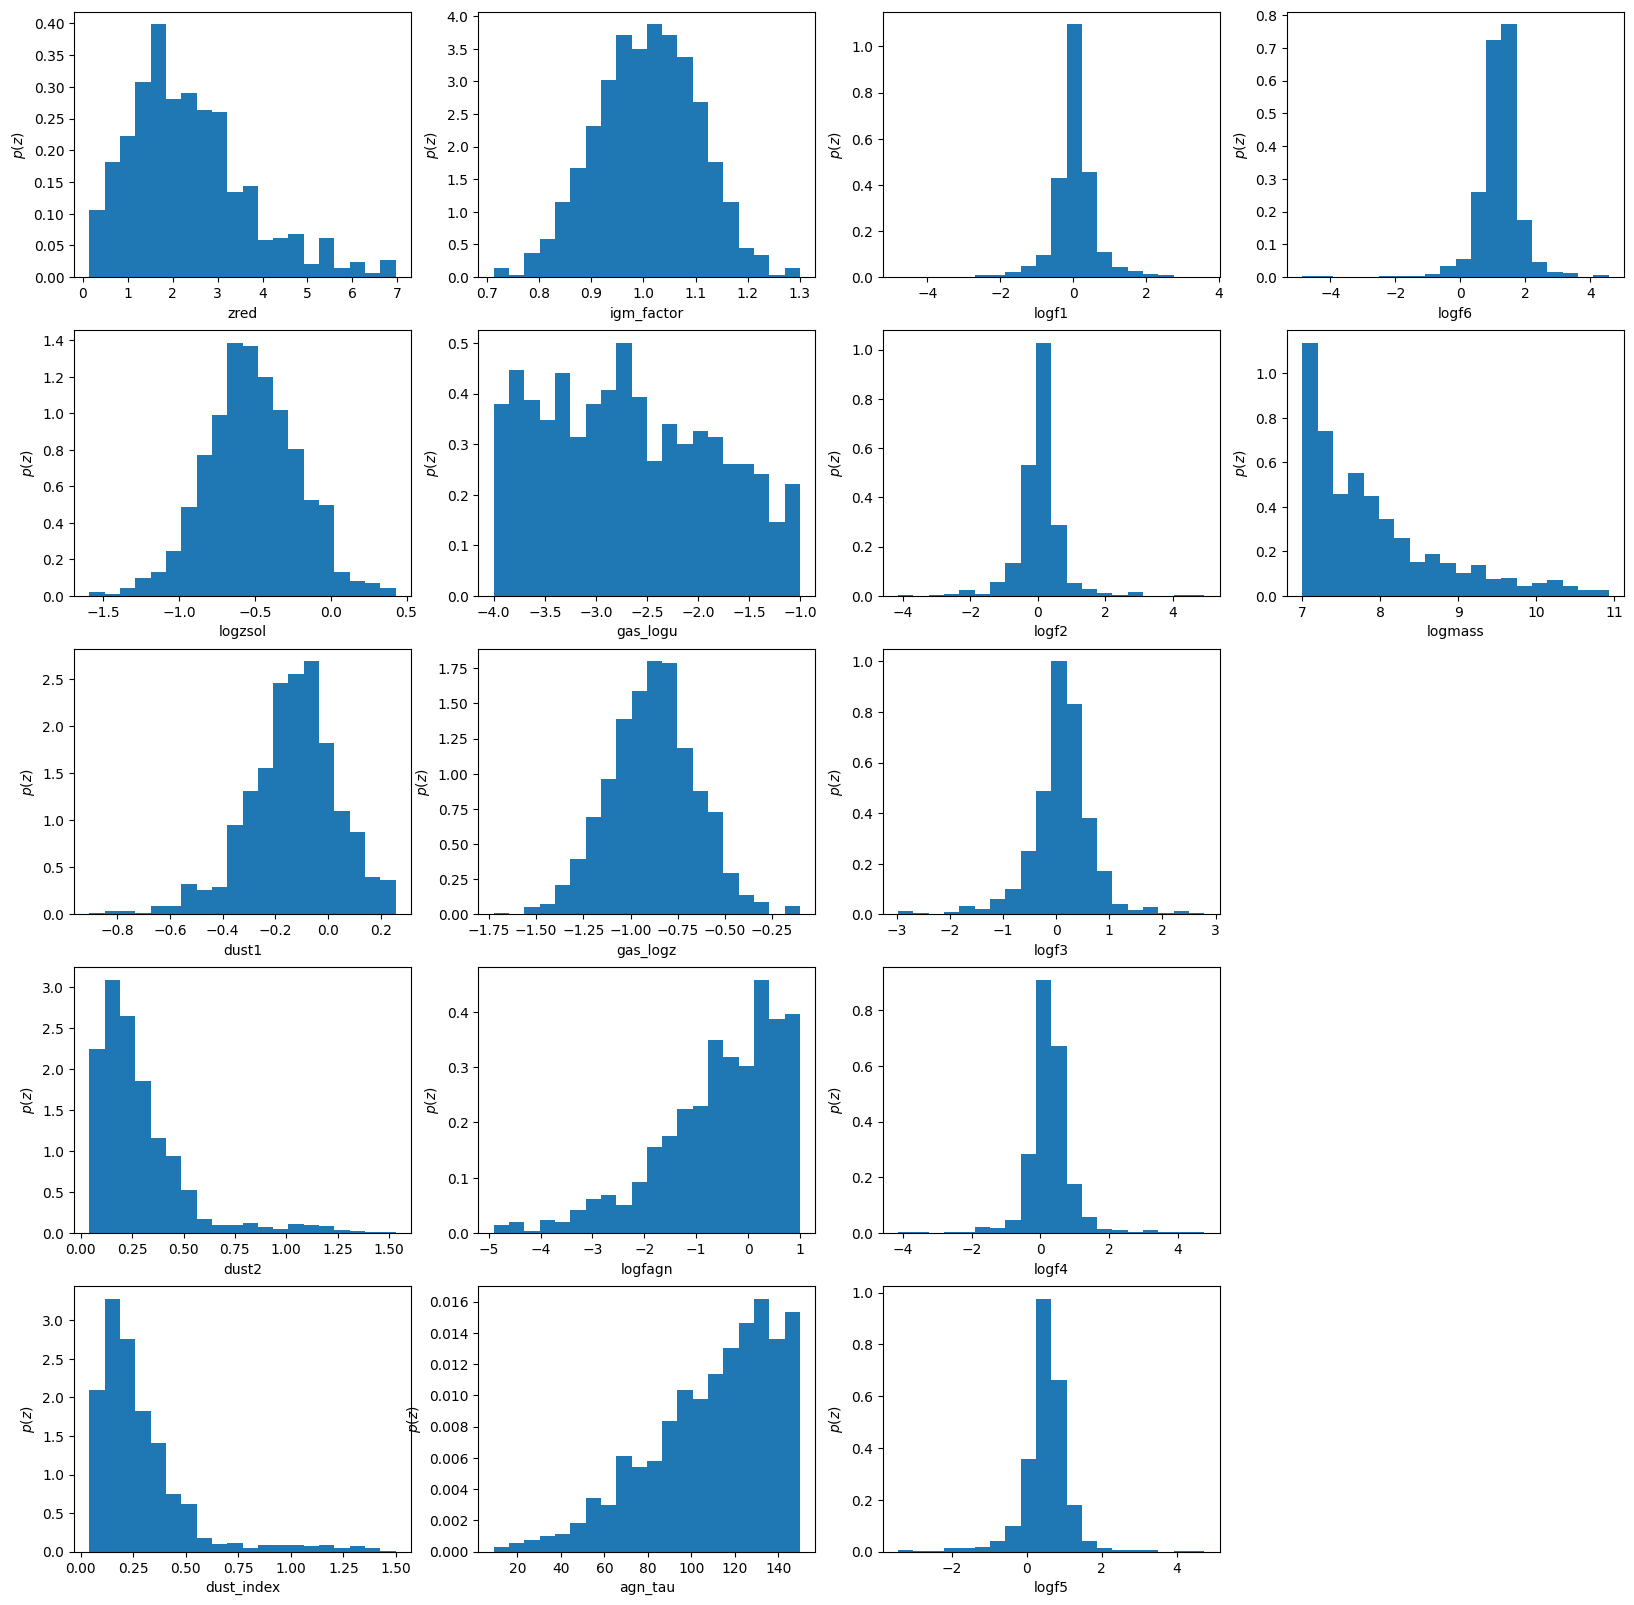

In [11]:
indx=0
pop.plot_galaxy_population(spsp[indx])

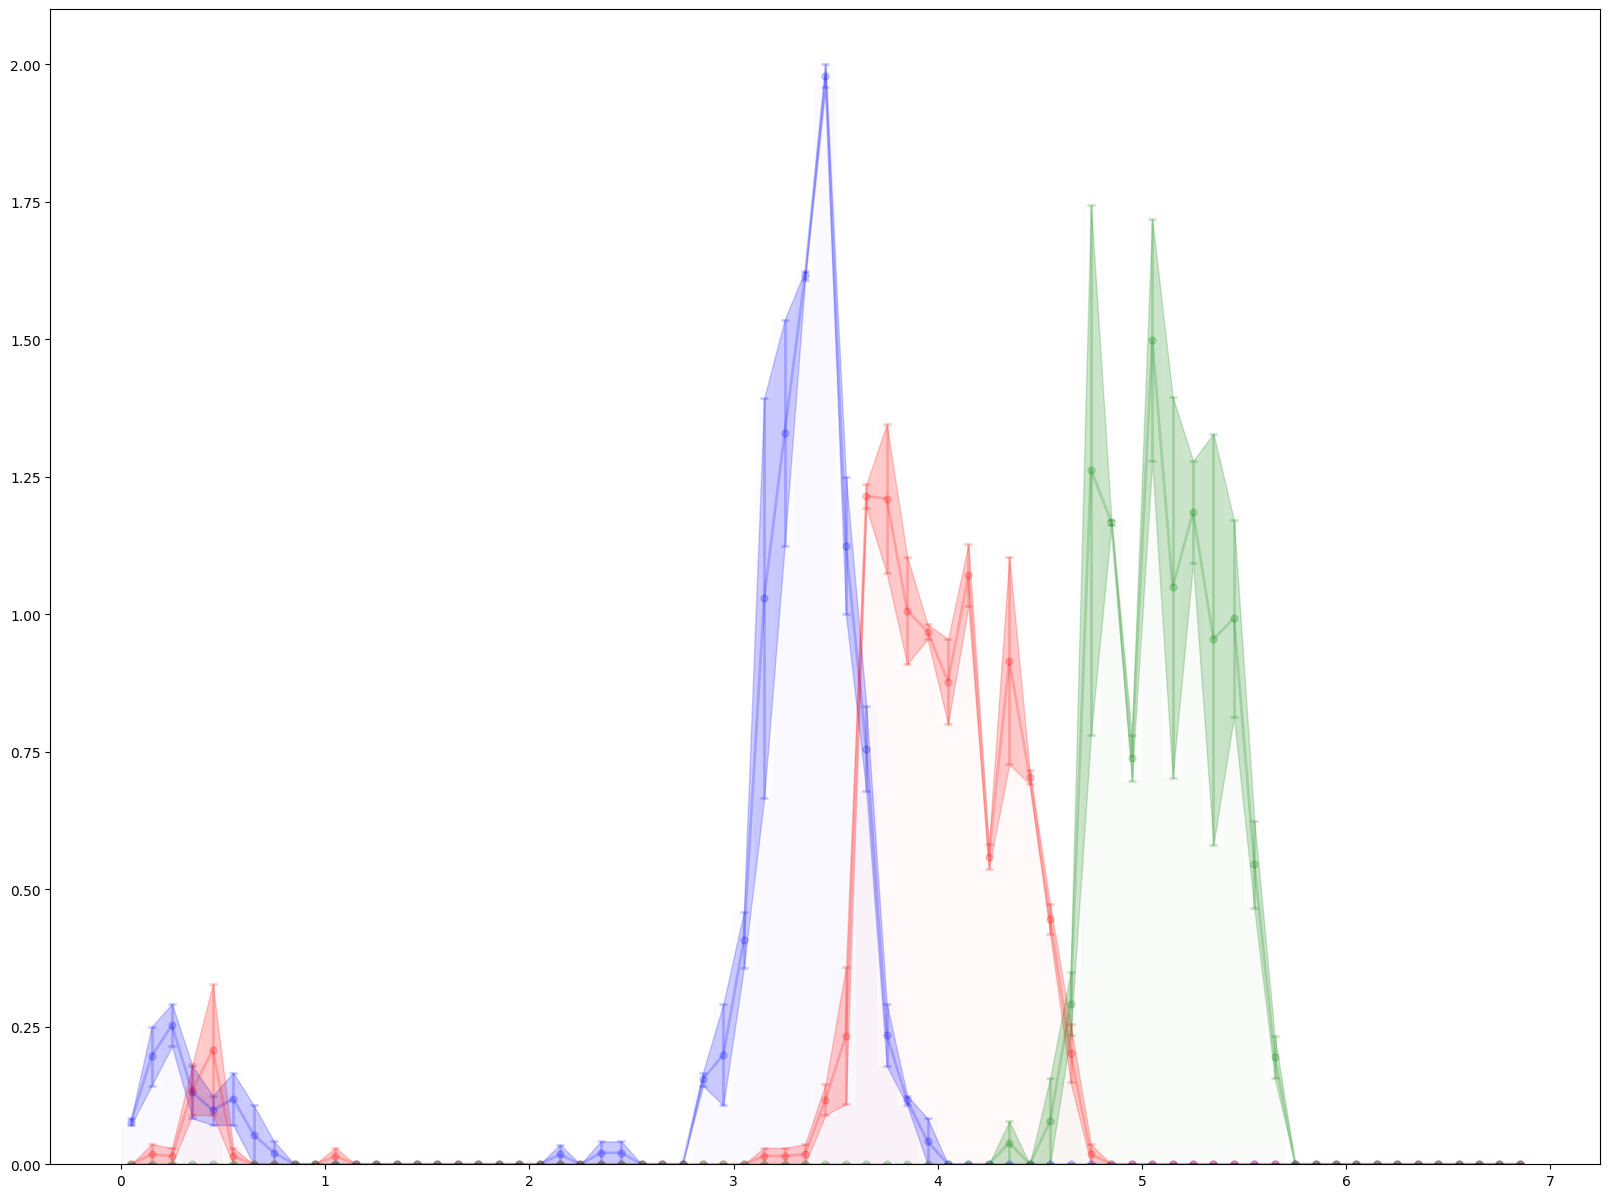

In [6]:
fig1, axes = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

colours = ['blue', 'red', 'green']
for drop in range(3):

    values = []
    x = []
    for n in range(nrealisations):
        hist = axes.hist(nzs[n][drop], density=True, bins=bins, alpha = 0.01, color=colours[drop])
        values.append(hist[0])
        x.append(hist[1])

    values = np.hstack((np.array(values)))
    x = np.array(x)
    x = np.hstack(((x+0.05)[:,:-1]))


    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'mean', bins=bins)
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'std', bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes.errorbar(bin_centers, bin_means, bin_std, alpha=0.2, ms=10, marker=".", elinewidth=2, capsize=3, capthick=2, lw=2, color=colours[drop])
    axes.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2, color=colours[drop])

In [13]:
#np.save("nzs_test4.npy", nzs)
#np.save("spsp_test4.npy", spsp)